<a href="https://colab.research.google.com/github/quangly/MovieRecommendation/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Description: Build a movie recommendation engine using Python

In [104]:
# Import the libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt

from pprint import pprint as pp

import pickle

In [20]:
#Load the data
from google.colab import files
uploaded = files.upload()

In [21]:
#source https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
df = pd.read_csv("imdb_top_1000.csv")
df['Movie_id'] = range(0,1000)
# shift column 'Name' to first position
first_column = df.pop('Movie_id')
  
# insert column using insert(position,column_name,
# first_column) function
df.insert(0, 'Movie_id', first_column)
#rename column Category to Genre
df = df.rename(columns={"Category": "Genre"})
df = df.rename(columns={"Series_Title": "Title"})
df.head(3)



,Movie_id,Poster_Link,Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


In [5]:
#get count of numbr of row/smovies in the data set and number of columns
df.shape

(1000, 17)

In [6]:
#create list of important columns for the recommendation engine
columns = ['Director', 'Star1','Star2','Star3','Star4','Genre','Title']

In [7]:
#show the data
df[columns].head(3)

,Director,Star1,Star2,Star3,Star4,Genre,Title
0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,Drama,The Shawshank Redemption
1,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,"Crime, Drama",The Godfather
2,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,"Action, Crime, Drama",The Dark Knight


In [8]:
#check for any missing values in the import columns
df[columns].isnull().values.any()
df.columns[df.isna().any()].tolist()
# df.loc[:, df.isnull().any()]

['Certificate', 'Meta_score', 'Gross']

In [9]:
# create a function to combine the values of the import columns into a single string
def get_important_features(data):
  important_features = []
  for i in range(0,data.shape[0]):
    important_features.append(data['Star1'][i] + \
                              ' ' + data['Star2'][i] + \
                              ' ' + data['Star3'][i] + \
                              ' ' + data['Star4'][i] + \
                              ' ' + data['Director'][i] + \
                              ' ' + data['Title'][i] + \
                              ' ' + data['Genre'][i])
  
  return important_features



In [27]:
#create a column to hold the combined strings
df['important_features'] = get_important_features(df)
# #show the data
# pd.set_option('display.max_rows', None)
# # df['important_features'].unique()

df.head(3)

,Movie_id,Poster_Link,Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,important_features
0,0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469",Tim Robbins Morgan Freeman Bob Gunton William ...
1,1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",Marlon Brando Al Pacino James Caan Diane Keato...
2,2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",Christian Bale Heath Ledger Aaron Eckhart Mich...


In [11]:
# convert the text to a matrix of token counts
cm = CountVectorizer().fit_transform(df['important_features'])

In [44]:
#get the cosine simimlarity matrix from the count matrix
cs = cosine_similarity(cm)
#Print the cosine similarity matrix - values 0 to 1. 1 = 100% similar to a movie
#each row is a movie and each column is a movie.
#first row/column is 1 b/c it's a movie similar to itself

# print(cs)

In [13]:
#get the shape of the cosine similarity matrix
# cs.shape

(1000, 1000)

In [73]:
#create a list of enumerations for the similarity score [(movie_id, similarity score), (..)]
def get_movie_scores(movie_id):

  scores = list(enumerate(cs[movie_id]))

  #Sort the list x[1] = similarity score descending score
  sorted_scores = sorted(scores, key = lambda x:x[1], reverse = True)
  #get every element exempt first element
  sorted_scores = sorted_scores[1:]
  return sorted_scores

#get list of unique movie id
movie_ids = df['Movie_id'].unique().tolist()
movie_score_list = []
for movie_id in movie_ids:
  movie_score_list.append({"movie_id": movie_id,
                           "sorted_scores": get_movie_scores(movie_id)})

# pp(movie_score_list[:3])

In [91]:
#get list of unique movie names
print(list(df['Title'].unique()))

['The Shawshank Redemption', 'The Godfather', 'The Dark Knight', 'The Godfather: Part II', '12 Angry Men', 'The Lord of the Rings: The Return of the King', 'Pulp Fiction', "Schindler's List", 'Inception', 'Fight Club', 'The Lord of the Rings: The Fellowship of the Ring', 'Forrest Gump', 'Il buono, il brutto, il cattivo', 'The Lord of the Rings: The Two Towers', 'The Matrix', 'Goodfellas', 'Star Wars: Episode V - The Empire Strikes Back', "One Flew Over the Cuckoo's Nest", 'Hamilton', 'Gisaengchung', 'Soorarai Pottru', 'Interstellar', 'Cidade de Deus', 'Sen to Chihiro no kamikakushi', 'Saving Private Ryan', 'The Green Mile', 'La vita è bella', 'Se7en', 'The Silence of the Lambs', 'Star Wars', 'Seppuku', 'Shichinin no samurai', "It's a Wonderful Life", 'Joker', 'Whiplash', 'The Intouchables', 'The Prestige', 'The Departed', 'The Pianist', 'Gladiator', 'American History X', 'The Usual Suspects', 'Léon', 'The Lion King', 'Terminator 2: Judgment Day', 'Nuovo Cinema Paradiso', 'Hotaru no hak

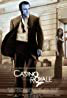

Casino Royale None

The 7 most recommended movies to Casino Royale are:




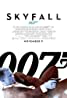

1: Skyfall None James Bond's loyalty to M is tested when her past comes back to haunt her. When MI6 comes under attack, 007 must track down and destroy the threat, no matter how personal the cost.




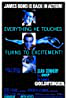

2: Goldfinger None While investigating a gold magnate's smuggling, James Bond uncovers a plot to contaminate the Fort Knox gold reserve.




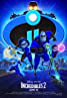

3: Incredibles 2 None The Incredibles family takes on a new mission which involves a change in family roles: Bob Parr (Mr. Incredible) must manage the house while his wife Helen (Elastigirl) goes out to save the world.




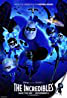

4: The Incredibles None A family of undercover superheroes, while trying to live the quiet suburban life, are forced into action to save the world.




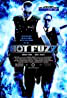

5: Hot Fuzz None A skilled London police officer is transferred to a small town with a dark secret.




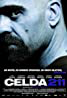

6: Celda 211 None The story of two men on different sides of a prison riot -- the inmate leading the rebellion and the young guard trapped in the revolt, who poses as a prisoner in a desperate attempt to survive the ordeal.




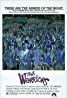

7: The Warriors None In the near future, a charismatic leader summons the street gangs of New York City in a bid to take it over. When he is killed, The Warriors are falsely blamed and now must fight their way home while every other gang is hunting them down.




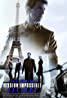

8: Mission: Impossible - Fallout None Ethan Hunt and his IMF team, along with some familiar allies, race against time after a mission gone wrong.




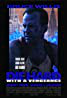

9: Die Hard: With a Vengeance None John McClane and a Harlem store owner are targeted by German terrorist Simon in New York City, where he plans to rob the Federal Reserve Building.




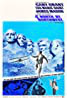

10: North by Northwest None A New York City advertising executive goes on the run after being mistaken for a government agent by a group of foreign spies.


In [103]:
#get the title of the movie that user likes
# "The Dark Knight" "Scarface" "Pulp Fiction" "Inception" "The Silence of the Lambs" The Hangover
title = "Casino Royale"
#find the movies id
movie_id = df[df.Title == title]['Movie_id'].values[0]
movie_title = df[df.Movie_id == movie_id]['Title'].values[0]
poster_url = df[df.Movie_id == movie_id]['Poster_Link'].values[0]
image = io.imread(poster_url) 
print(movie_title, cv2_imshow(image))

#create a loop to print the first 7 similar movies
j = 0

print('\nThe 7 most recommended movies to', title, 'are:')

#get sorted scores based on movie_id from trained model
sorted_scores = next(item["sorted_scores"] for item in movie_score_list if item["movie_id"] == movie_id)

for item in sorted_scores[:10]:
  movie_title = df[df.Movie_id == item[0]]['Title'].values[0]
  poster_url = df[df.Movie_id == item[0]]['Poster_Link'].values[0]
  overview = df[df.Movie_id == item[0]]['Overview'].values[0]
  image = io.imread(poster_url)
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat((image, image_2))

  print('\n')
  print(str(j+1) + ':', movie_title, cv2_imshow(image), overview)
  j = j+1

